In [1]:
# Data handling and statistical analysis 
import pandas as pd
from pandas_datareader import data
import numpy as np
from scipy import stats
from datetime import datetime
import datetime as dt
from dateutil.relativedelta import relativedelta

# Data visualization 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Optimization and allocation
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import black_litterman, BlackLittermanModel
from scipy.optimize import minimize

# Financial data 
import quantstats as qs
import ta
import yfinance as yf

# Linear Regression Model
from sklearn.linear_model import LinearRegression

# Enabling Plotly offline
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

# Datetime and hiding warnings 
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Getting daily returns for 4 different US stocks in the same time window
today = datetime.today()
start_date = today - relativedelta(years=5)

# Getting daily returns and converting timezone for 4 different US stocks in the same time window
tickers = ["GS", "AXP", "LOW", "AMD"]
returns = {ticker: qs.utils.download_returns(ticker).loc[start_date:today].tz_localize(None) for ticker in tickers}

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [3]:
# Keep the variables separate
gs, axp, low, amd = (returns[ticker] for ticker in tickers)


Goldman Sachs Daily Returns Plot:



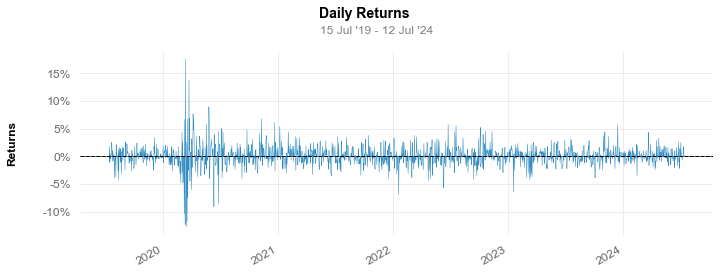




Amex Daily Returns Plot:



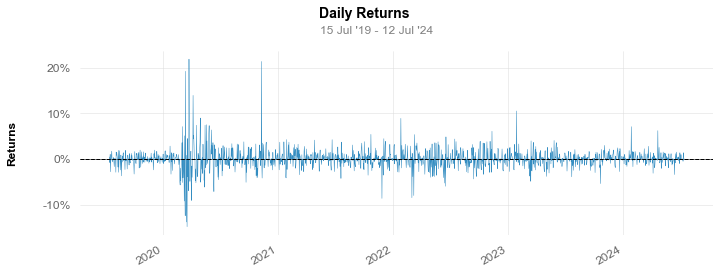




Lowes Daily Returns Plot:



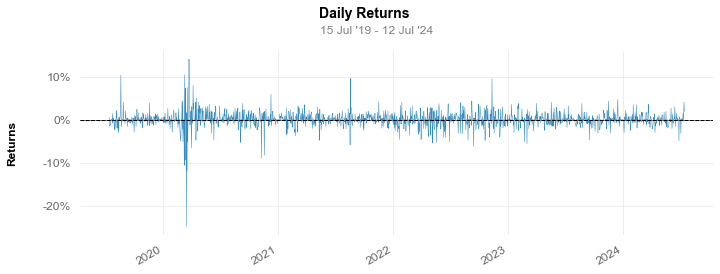




Advances Micro Devices, Inc. Daily Returns Plot:



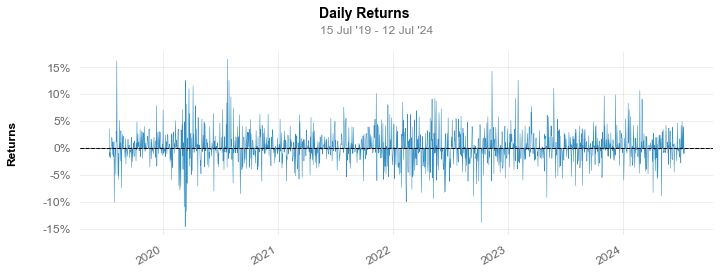

In [4]:
names = ["Goldman Sachs", "Amex", "Lowes", "Advances Micro Devices, Inc."]

for ticker, name in zip(tickers, names):
    print(f'\n{name} Daily Returns Plot:\n')
    qs.plots.daily_returns(returns[ticker], benchmark='URTH') # benchmark is MSCI World Index 
    print('\n')

In [5]:
# Getting dataframes info for Stocks using yfinance
data = yf.download(tickers, start = start_date, end = today)["Adj Close"]
data

[*********************100%%**********************]  4 of 4 completed


Ticker,AMD,AXP,GS,LOW
Date,,,,
2019-07-12,33.209999,119.313454,189.100204,98.060013
2019-07-15,34.389999,119.882256,187.014252,98.580421
2019-07-16,33.849998,119.406700,190.496765,97.238281
2019-07-17,33.599998,118.492920,188.534546,95.804810
2019-07-18,33.000000,119.723740,189.612900,94.727409
...,...,...,...,...
2024-07-05,171.899994,235.630005,464.750000,213.889999
2024-07-08,178.690002,234.509995,464.820007,217.149994
2024-07-09,177.100006,237.750000,472.829987,216.330002


In [6]:
daily_df = data.pct_change().dropna()
daily_df

Ticker,AMD,AXP,GS,LOW
Date,,,,
2019-07-15,0.035531,0.004767,-0.011031,0.005307
2019-07-16,-0.015702,-0.003967,0.018622,-0.013615
2019-07-17,-0.007386,-0.007653,-0.010301,-0.014742
2019-07-18,-0.017857,0.010387,0.005720,-0.011246
2019-07-19,-0.014849,-0.027882,-0.004662,-0.012048
...,...,...,...,...
2024-07-05,0.048810,0.002638,-0.006775,0.002766
2024-07-08,0.039500,-0.004753,0.000151,0.015241
2024-07-09,-0.008898,0.013816,0.017232,-0.003776


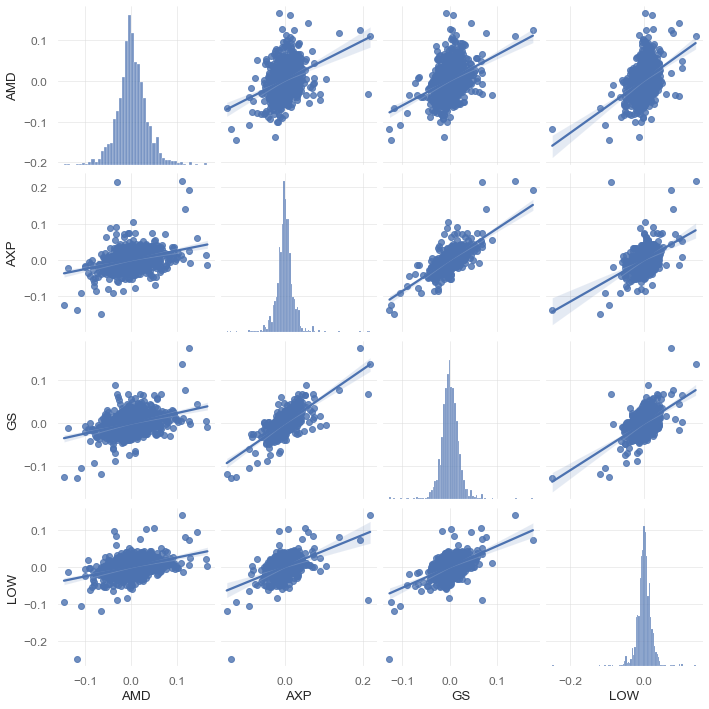

In [7]:
# Pairplots
sns.pairplot(daily_df, kind = 'reg')
plt.show()

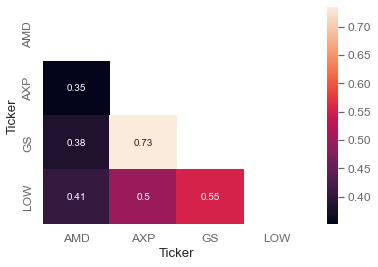

In [8]:
# Correlation Matrix
corr = daily_df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, annot=True, mask = mask)
plt.show()

In [9]:
# Loading data from msci world
msci = qs.utils.download_returns('URTH')
msci = msci.loc[start_date:today]
msci.index = msci.index.tz_localize(None)
msci

[*********************100%%**********************]  1 of 1 completed


Date
2019-07-15   -0.000539
2019-07-16   -0.003021
2019-07-17   -0.003571
2019-07-18    0.001846
2019-07-19   -0.004011
                ...   
2024-07-08   -0.001063
2024-07-09    0.000599
2024-07-10    0.010570
2024-07-11   -0.004934
2024-07-12    0.007470
Name: Close, Length: 1258, dtype: float64

In [10]:
# Removing indexes
tickers1 = ["msci", "GS", "AXP", "LOW", "AMD"]
data_frames = [msci, gs, axp, low, amd]
no_index_dfs = {ticker: df.reset_index(drop=True) for ticker, df in zip(tickers1, data_frames)}

msci_no_index, gs_no_index, axp_no_index, low_no_index, amd_no_index = (no_index_dfs[ticker] for ticker in tickers1)
msci_no_index

0      -0.000539
1      -0.003021
2      -0.003571
3       0.001846
4      -0.004011
          ...   
1253   -0.001063
1254    0.000599
1255    0.010570
1256   -0.004934
1257    0.007470
Name: Close, Length: 1258, dtype: float64

In [11]:
# Fitting linear relation among the stocks' returns and Benchmark
no_index_dfs = [gs_no_index, axp_no_index, low_no_index, amd_no_index]
dfs = [gs, axp, low, amd]

for ticker, no_index_df, df, name in zip(tickers, no_index_dfs, dfs, names):
    X = msci_no_index.values.reshape(-1, 1)
    y = no_index_df.values.reshape(-1, 1)
    linreg = LinearRegression().fit(X, y)
    beta = linreg.coef_[0]
    alpha = linreg.intercept_

    # Calculating Sharpe ratio
    sharpe_ratio = qs.stats.sharpe(df).round(2)

    print(f'\n{name} beta: ', beta.round(3))
    print(f'\n{name} alpha: ', alpha.round(3))
    print(f'\nSharpe Ratio for {name}: ', sharpe_ratio)


Goldman Sachs beta:  [1.213]

Goldman Sachs alpha:  [0.]

Sharpe Ratio for Goldman Sachs:  0.66

Amex beta:  [1.382]

Amex alpha:  [0.]

Sharpe Ratio for Amex:  0.52

Lowes beta:  [1.124]

Lowes alpha:  [0.]

Sharpe Ratio for Lowes:  0.64

Advances Micro Devices, Inc. beta:  [1.601]

Advances Micro Devices, Inc. alpha:  [0.001]

Sharpe Ratio for Advances Micro Devices, Inc.:  0.91


In [12]:
# Define the number of assets
num_assets = len(tickers)
init_guess = np.array([1 / num_assets] * num_assets)
init_guess

array([0.25, 0.25, 0.25, 0.25])

In [13]:
weights = init_guess # Defining weights for each stock
portfolio_daily_returns = (data.pct_change().dropna() * weights).sum(axis=1) # Creating portfolio multiplying each stock for its respective weight 
portfolio = portfolio_daily_returns
portfolio

Date
2019-07-15    0.008644
2019-07-16   -0.003666
2019-07-17   -0.010020
2019-07-18   -0.003249
2019-07-19   -0.014860
                ...   
2024-07-05    0.011860
2024-07-08    0.012535
2024-07-09    0.004594
2024-07-10    0.019225
2024-07-11    0.007448
Length: 1257, dtype: float64

# Original Portfolio vs MSCI World

[*********************100%%**********************]  1 of 1 completed


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2019-07-16   2019-07-16
End Period                 2024-07-11   2024-07-11
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          63.22%       231.58%
CAGR﹪                     7.01%        18.03%

Sharpe                     0.59         0.95
Prob. Sharpe Ratio         90.07%       98.16%
Smart Sharpe               0.53         0.85
Sortino                    0.81         1.36
Smart Sortino              0.73         1.22
Sortino/√2                 0.57         0.96
Smart Sortino/√2           0.51         0.87
Omega                      1.19         1.19

Max Drawdown               -34.01%      -41.78%
Longest DD Days            820          747
Volatility (ann.)          20.34%       30.27%
R^2                        0.8          0.8
Information Ratio          0.07         0.07
Calmar             

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-02-20,2020-03-18,2020-07-28,160,-41.784572,-41.368036
2,2021-11-26,2022-10-14,2023-12-12,747,-34.120541,-32.591288
3,2020-10-13,2020-10-30,2020-11-06,25,-11.172030,-10.384877
4,2020-09-03,2020-09-23,2020-10-09,37,-10.877123,-9.514224
5,2019-07-25,2019-08-05,2019-10-25,93,-9.642323,-9.314901


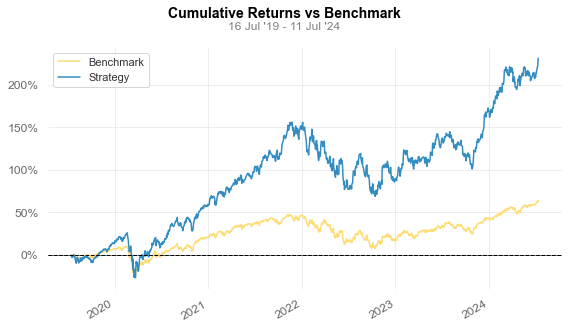

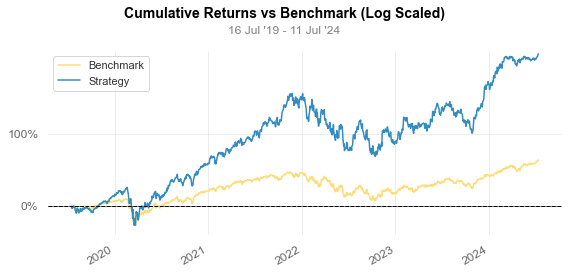

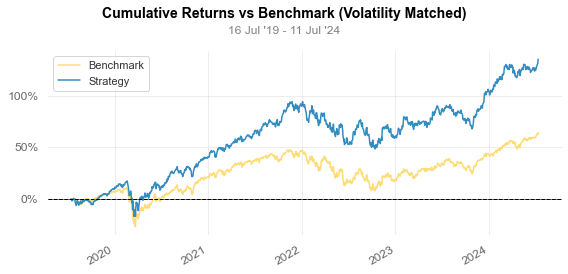

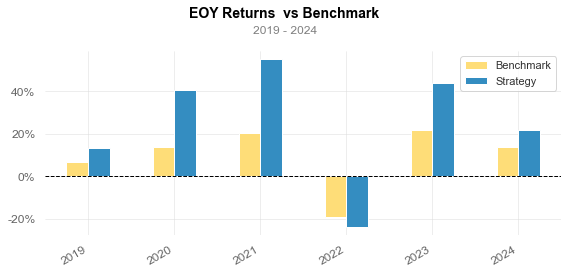

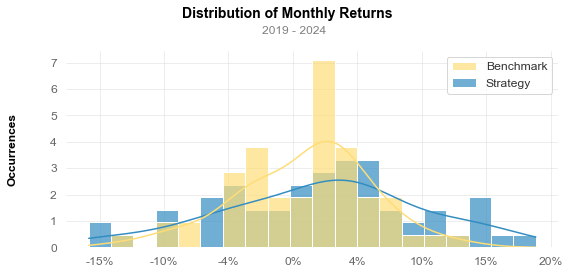

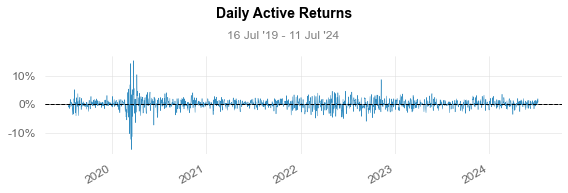

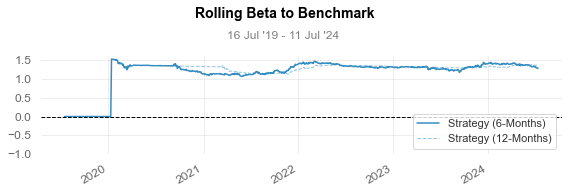

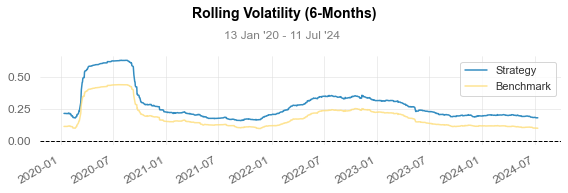

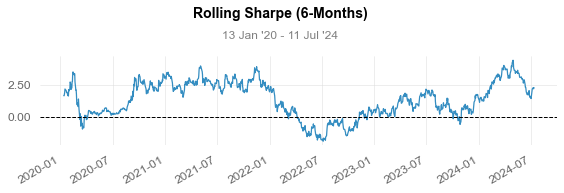

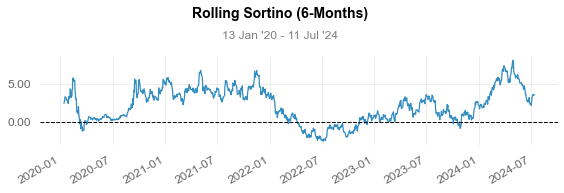

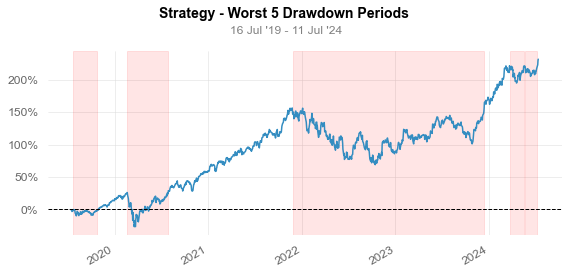

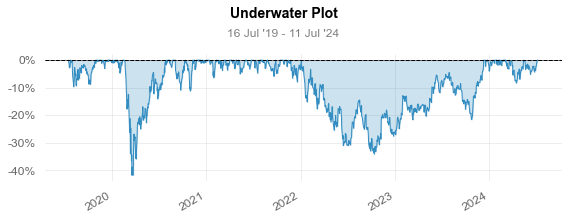

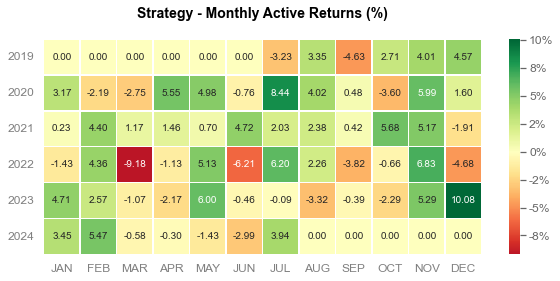

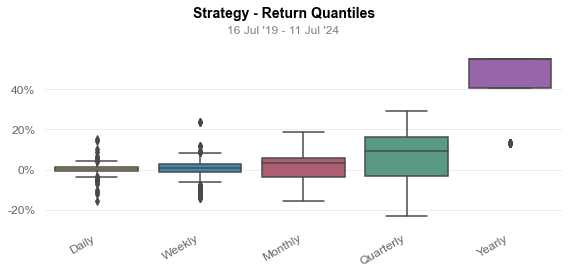

In [14]:
qs.reports.full(portfolio, benchmark = 'URTH')

# Portfolio Optimization

Portfolio optimization is the process of selecting the optimal combination of assets and weights to maximize returns and minimize risk. This process involves selecting the most appropriate weights for each asset,by taking into account the historical performance of the assets, their correlations with each other, and other relevant factors such as market conditions and economic outlook. The main goal is to create a well-diversified portfolio that balances risk and returns, and that aligns with the investor's risk tolerance.

# Mean-Variance Optimization Model

- Maximize the expected return of a portfolio while minimizing its risk (allocate weights across a portfolio for maximal Sharpe ratio)
- Markowitz's contribution is famous for the efficient frontier

In [15]:
# Calculating the annualized expected returns and the annualized sample covariance matrix

# Expected returns: arithmetic mean of each asset's daily percentage changes
mu = expected_returns.mean_historical_return(data)

# Choose a risk model that quantifies the level of risk in each asset.
# Covariance matrix describes the volatilities of assets and the degree to which they are co-dependent.
S = risk_models.sample_cov(data) 

In [16]:
mu

Ticker
AMD    0.406321
AXP    0.149197
GS     0.204934
LOW    0.186122
dtype: float64

In [17]:
S

Ticker,AMD,AXP,GS,LOW
Ticker,,,,
AMD,0.274251,0.070096,0.065194,0.069656
AXP,0.070096,0.144895,0.090604,0.062240
GS,0.065194,0.090604,0.104956,0.058896
LOW,0.069656,0.062240,0.058896,0.107306


In [18]:
# Optimize for max Sharpe ratio
ef = EfficientFrontier(mu, S) # Providing expected returns and covariance matrix as input
ef.max_sharpe() # Optimizing weights for Sharpe ratio maximization 
max_sharpe_weights = ef.clean_weights() # clean_weights rounds the weights and clips near-zeros

# Printing optimized weights and expected performance for portfolio
max_sharpe_weights

OrderedDict([('AMD', 0.47657),
             ('AXP', 0.0),
             ('GS', 0.37604),
             ('LOW', 0.14739)])

In [19]:
# Creating new portfolio with optimized weights
new_weights = list(max_sharpe_weights.values())
mean_variance_portfolio = (data.pct_change().dropna() * new_weights).sum(axis=1) # Creating portfolio multiplying each stock for its respective weight 
mean_variance_portfolio 

Date
2019-07-15    0.013567
2019-07-16   -0.002487
2019-07-17   -0.009566
2019-07-18   -0.008017
2019-07-19   -0.010605
                ...   
2024-07-05    0.021122
2024-07-08    0.021127
2024-07-09    0.001683
2024-07-10    0.026284
2024-07-11    0.001050
Length: 1257, dtype: float64

# Mean-Variance Optimization Model vs Original Portfolio

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2019-07-15   2019-07-15
End Period                 2024-07-11   2024-07-11
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          234.45%      326.61%
CAGR﹪                     18.16%       22.21%

Sharpe                     0.95         1.02
Prob. Sharpe Ratio         98.22%       98.79%
Smart Sharpe               0.86         0.92
Sortino                    1.37         1.49
Smart Sortino              1.24         1.35
Sortino/√2                 0.97         1.05
Smart Sortino/√2           0.88         0.96
Omega                      1.2          1.2

Max Drawdown               -41.78%      -45.18%
Longest DD Days            747          749
Volatility (ann.)          30.26%       34.52%
R^2                        0.88         0.88
Information Ratio          0.03         0.03
Calmar             

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2021-11-26,2022-10-14,2023-12-14,749,-45.182539,-43.614624
2,2020-02-20,2020-03-18,2020-07-21,153,-38.114832,-36.639312
3,2024-03-08,2024-04-19,2024-07-09,124,-14.986924,-13.856372
4,2020-09-03,2020-09-23,2020-11-23,82,-13.390330,-12.369718
5,2019-07-25,2019-08-05,2019-10-25,93,-12.853805,-11.579618


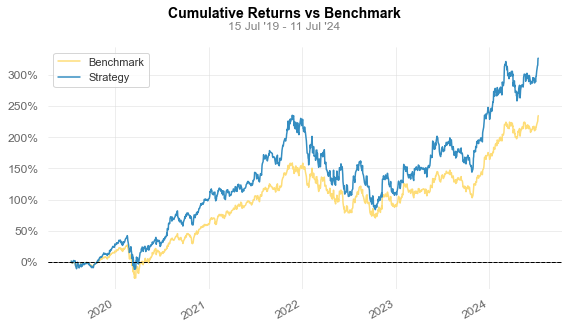

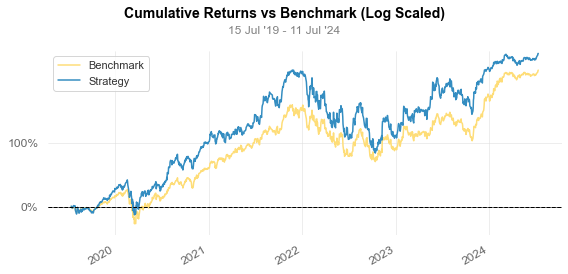

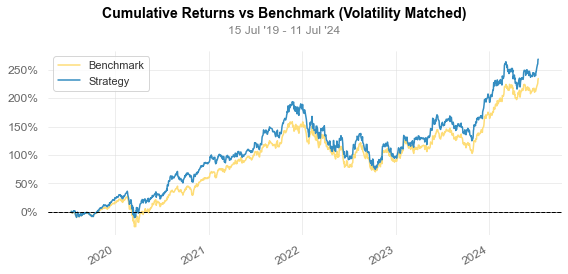

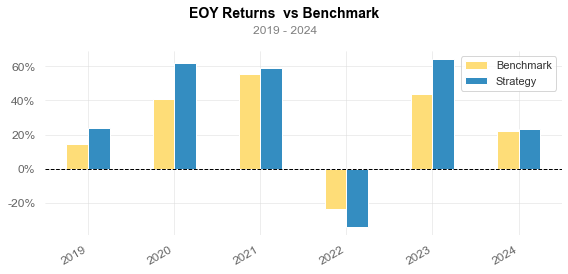

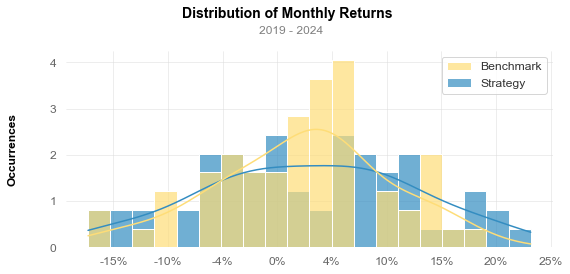

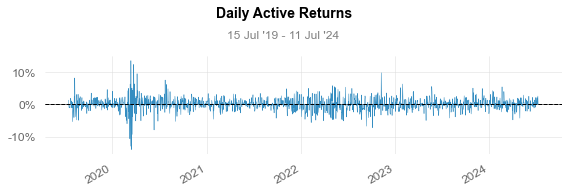

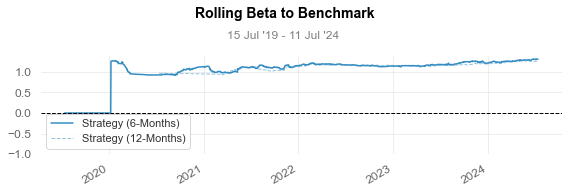

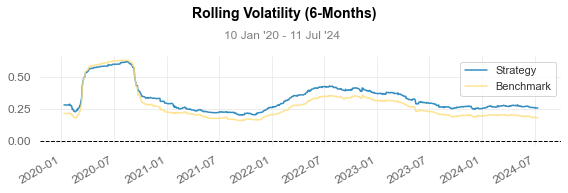

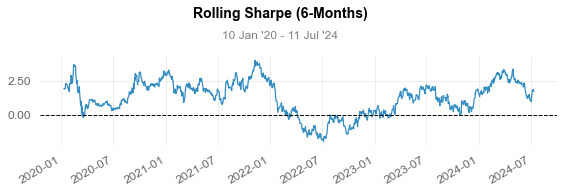

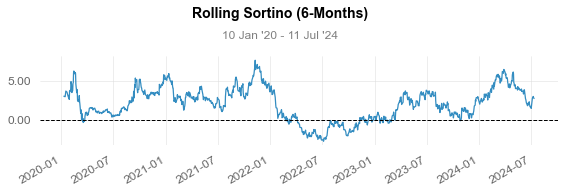

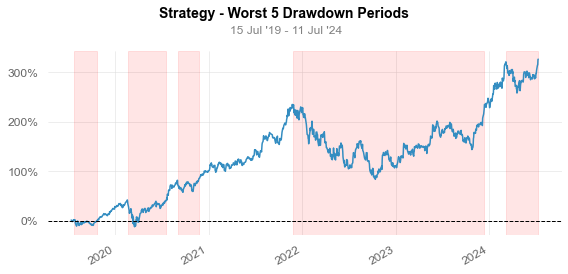

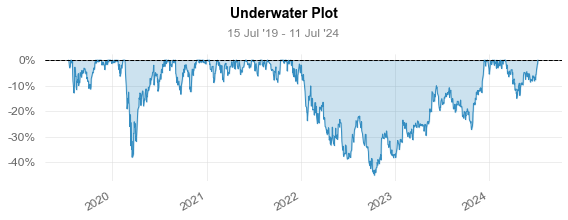

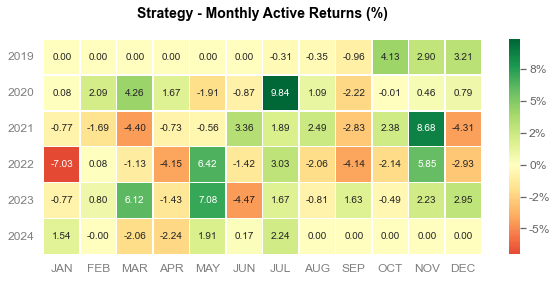

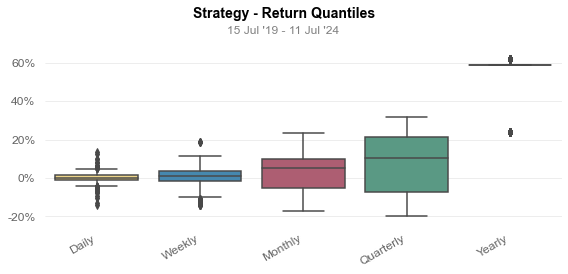

In [20]:
qs.reports.full(mean_variance_portfolio, benchmark = portfolio)

# Lagrangian Approach -- Constraint Optimization

- The Lagrangian approach is a powerful method used in multivariable calculus to find the optimal solution to a problem with given constraints. By using this technique, we can identify the best possible solution while adhering to specific rules or restrictions. The method involves finding the gradients of the objective function and the constraint function, and then setting these gradients proportionally to each other.


## A Very Simple Example

### Objective:

To maximize $\ f(x, y) = x^2 y \ $ subject to the constraint $\  x^2 + y^2 = 1 \ $

### Lagrangian Function

The Lagrangian function is defined as:

$$
\mathcal{L}(x, y, \lambda) = f(x, y) + \lambda g(x, y)
$$

where $\ g(x, y) = x^2 + y^2 - 1 $

### Gradients

The gradients are:

$$
\nabla f(x, y) = \lambda \nabla g(x, y)
$$

This leads to the system of equations:

$$
\nabla f(x_m, y_m) = \lambda \nabla g(x_m, y_m)
$$

### Calculations

1. **Objective Function Gradient**:

$$
\nabla f(x, y) = \left[ \frac{\partial}{\partial x}(x^2 y), \frac{\partial}{\partial y}(x^2 y) \right] = \left[ 2xy, x^2 \right]
$$

2. **Constraint Function Gradient**:

$$
\nabla g(x, y) = \left[ \frac{\partial}{\partial x}(x^2 + y^2 - 1), \frac{\partial}{\partial y}(x^2 + y^2 - 1) \right] = \left[ 2x, 2y \right]
$$

### System of Equations

Setting up the system of equations:

$$
\left[ 2xy, x^2 \right] = \lambda \left[ 2x, 2y \right]
$$

This gives:

$$
2xy = \lambda 2x \\
x^2 = \lambda 2y \\
x^2 + y^2 = 1
$$

### Solving the System

From $\ 2xy = \lambda 2x \ $:

$$
y = \lambda \quad \text{(assuming } x \neq 0\text{)}
$$

From $ \ x^2 = \lambda 2y \ $:

$$
x^2 = 2y^2 \\
x^2 = 2 \left( \frac{1}{3} \right) = \frac{2}{3}
$$

Substituting back:

$$
x = \pm \sqrt{\frac{2}{3}} \\
y = \pm \sqrt{\frac{1}{3}}
$$

### Maximum Value

Evaluating $ \ f(x, y) \ $ at the critical points:

$$
f \left( \sqrt{\frac{2}{3}}, \sqrt{\frac{1}{3}} \right) = \left( \sqrt{\frac{2}{3}} \right)^2 \left( \sqrt{\frac{1}{3}} \right) = \frac{2}{3} \sqrt{\frac{1}{3}}
$$

Thus, the maximum value of $ \ f(x, y) \ $ subject to the constraint $ \ x^2 + y^2 = 1 \ $ is $ \ \frac{2}{3} \sqrt{\frac{1}{3}} \ $.

## Constraints 
1. Sum of Weights: The sum of all weights must be equal to 1.
2. Risk Constraint: The portfolio's volatility must be less than 50%.
3. Bounds: Each asset's weight must be between 0% and 90% (no short selling).
    
## Optimization
- Using scipy.optimize.minimize to find the weights that maximize the Sharpe ratio while adhering to the constraints. 
- Maximize a function can be achieved by minimizing its negative

In [21]:
# Constraints
max_weight = 0.9
min_weight = 0
max_volatility = 0.50

# Calculates the portfolio return given the weights and returns
def portfolio_return(weights, returns):
    return weights.T @ returns

# Calculates the portfolio variance given the weights and covariance matrix
def portfolio_variance(weights, cov_matrix): 
    return weights.T @ cov_matrix @ weights
# weights.T: The transpose of the weights vector, which converts it from a column vector to a row vector.
# weights.T @ cov_matrix: Multiplies the transposed weights vector (row vector) by the covariance matrix. This operation results in another row vector.
# (weights.T @ cov_matrix) @ weights: Multiplies the resulting row vector by the original weights vector (now a column vector). This final operation gives a single scalar value, which represents the portfolio variance.

# Computes the portfolio volatility as the square root of the variance
def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(portfolio_variance(weights, cov_matrix))

# Calculates the Sharpe ratio with (portfolio return - risk free rate)/portfolio volatility
def sharpe_ratio(weights, returns, cov_matrix, risk_free_rate=0.05):
    port_return = portfolio_return(weights, returns)
    port_volatility = portfolio_volatility(weights, cov_matrix)
    return (port_return - risk_free_rate) / port_volatility

# Define the objective function for scipy.optimize
def objective_function(weights, returns, cov_matrix, risk_free_rate=0.05):
    # We minimize the negative Sharpe ratio to maximize the Sharpe ratio
    return -sharpe_ratio(weights, returns, cov_matrix, risk_free_rate)

# Constraints for optimization
constraints = [
    {"type": "eq", "fun": lambda weights: np.sum(weights) - 1},  # Sum of weights is 1
    {"type": "ineq", "fun": lambda weights: max_volatility - portfolio_volatility(weights, S)},  # Risk constraint
]

# Bounds for the weights (no short selling, max weight, and min weight)
bounds = [(min_weight, max_weight)] * num_assets

# Perform the optimization
result = minimize(
    objective_function,
    init_guess,
    args=(mu, S), # Additional arguments for the objective function (mu for expected returns and S for covariance matrix).
    method="SLSQP", # Sequential Least Squares Programming: Iterative method for nonlinear optimization, 
                    # handling equality and inequality constraints Common in engineering and economics.
                    # Effective for smooth objective functions and constraints.
    bounds=bounds,
    constraints=constraints
)

# Extract optimized weights
optimized_weights = result.x
print (optimized_weights)

lagrange_portfolio = (data.pct_change().dropna() * optimized_weights).sum(axis=1)
lagrange_portfolio

[0.5530347  0.         0.35627928 0.09068602]


Date
2019-07-15    0.016201
2019-07-16   -0.003284
2019-07-17   -0.009091
2019-07-18   -0.008858
2019-07-19   -0.010965
                ...   
2024-07-05    0.024831
2024-07-08    0.023281
2024-07-09    0.000876
2024-07-10    0.027837
2024-07-11   -0.002118
Length: 1257, dtype: float64

# Lagrangian Approach vs Mean-Variance Optimization

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2019-07-15   2019-07-15
End Period                 2024-07-11   2024-07-11
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          326.61%      351.5%
CAGR﹪                     22.21%       23.17%

Sharpe                     1.02         1.01
Prob. Sharpe Ratio         98.79%       98.76%
Smart Sharpe               0.93         0.92
Sortino                    1.49         1.49
Smart Sortino              1.36         1.36
Sortino/√2                 1.05         1.05
Smart Sortino/√2           0.96         0.96
Omega                      1.19         1.19

Max Drawdown               -45.18%      -48.44%
Longest DD Days            749          753
Volatility (ann.)          34.52%       36.68%
R^2                        0.99         0.99
Information Ratio          0.03         0.03
Calmar             

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2021-11-30,2022-10-14,2023-12-22,753,-48.443069,-46.921363
2,2020-02-20,2020-03-18,2020-07-21,153,-37.204889,-35.505003
3,2024-03-08,2024-04-19,2024-07-09,124,-17.171906,-16.234184
4,2020-09-02,2020-09-23,2020-11-23,83,-14.272353,-13.328053
5,2019-07-25,2019-08-05,2019-10-25,93,-13.716497,-12.650944


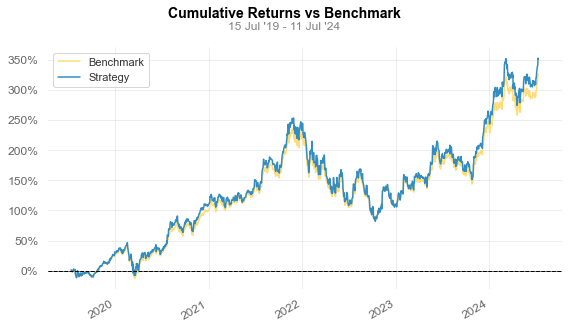

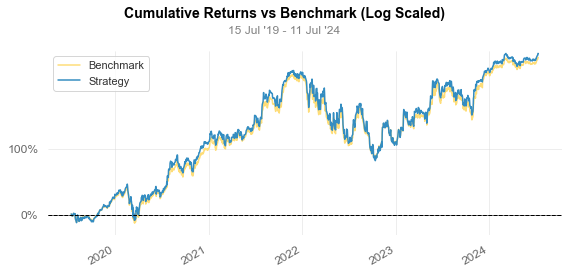

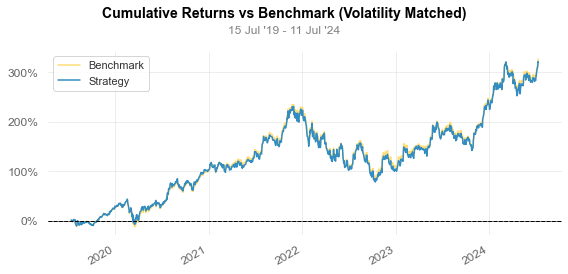

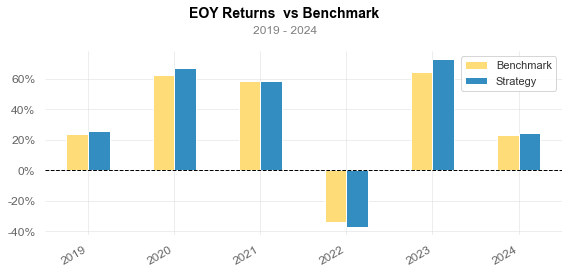

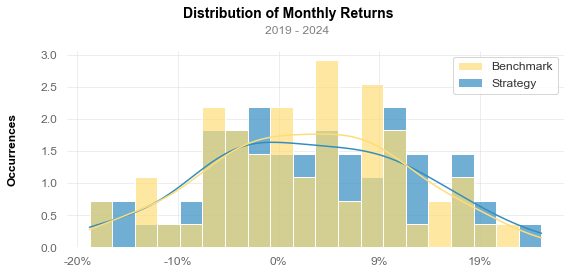

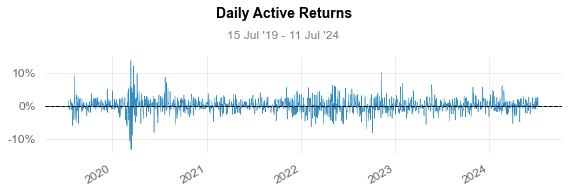

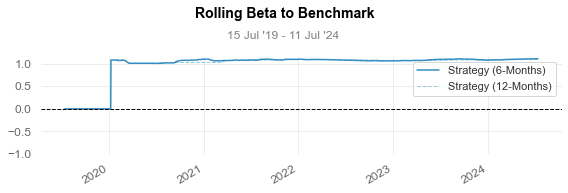

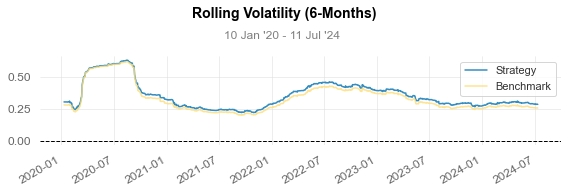

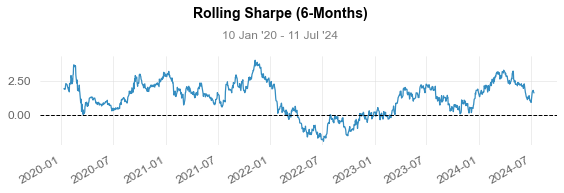

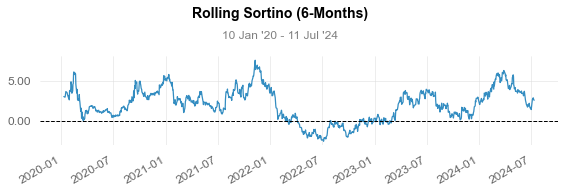

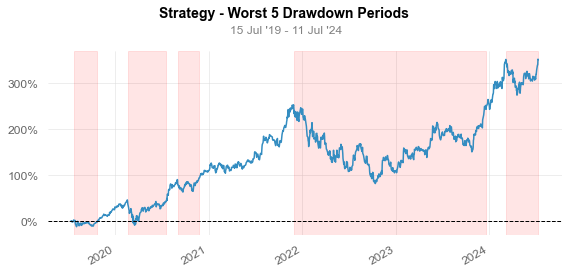

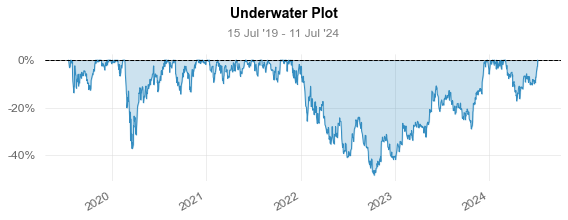

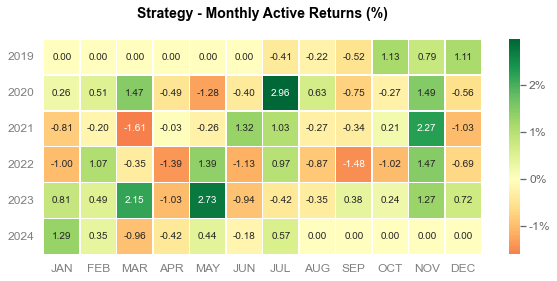

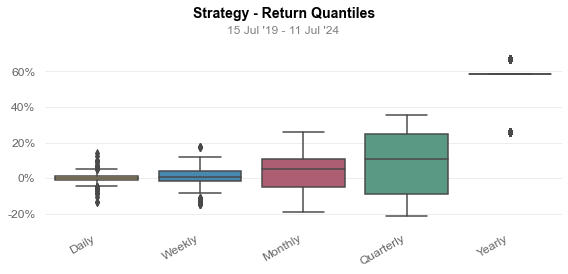

In [22]:
qs.reports.full(lagrange_portfolio, benchmark = mean_variance_portfolio)

# Black-Litterman Allocation Model

- A Bayesian approach to asset allocation: it combines a prior estimate of returns with the investor's particular views on the expected returns to generate an optimal allocation. Multiple sources of information can be used to establish the prior estimate of returns, and the model allows investors to provide a confidence level for their views, which is then used to optimize allocation.
- The Black-Litterman formula calculates a weighted average between the prior estimate of returns and the views, with the weighting determined by the level of confidence for each view.
- A commonly used approach for determining a prior estimate of returns involves relying on the market's expectations, which are reflected in the asset's market capitalization.

In [23]:
# Obtaining market cap of the stocks
market_caps = {}
for asset in tickers:
    ticker = yf.Ticker(asset)
    info = ticker.info
    market_caps[asset] = info.get('marketCap')

# Convert to a DataFrame for visualization or further analysis
market_caps_df = pd.DataFrame(list(market_caps.items()), columns=['Ticker', 'Market Cap'])
market_caps_df

,Ticker,Market Cap
0,GS,154743554048
1,AXP,171647270912
2,LOW,133386977280
3,AMD,293538070528


In [24]:
# Obtaining closing prices for MSCI World
market_prices = yf.download('URTH',start = start_date, end = today)['Adj Close']
market_prices

[*********************100%%**********************]  1 of 1 completed


Date
2019-07-12     85.247513
2019-07-15     85.201546
2019-07-16     84.944130
2019-07-17     84.640762
2019-07-18     84.797035
                 ...    
2024-07-05    150.500000
2024-07-08    150.339996
2024-07-09    150.429993
2024-07-10    152.020004
2024-07-11    151.270004
Name: Adj Close, Length: 1258, dtype: float64

In [25]:
# Obtaining market-implied risk aversion, delta

# Estimate the level of risk aversion among market participants, represented by a parameter known as delta, 
# which we calculate using the closing prices of MSCI World. 
# The higher the value for delta, the greater the market's risk aversion.

delta = black_litterman.market_implied_risk_aversion(market_prices)
delta

2.81466533418875

In [26]:
S

Ticker,AMD,AXP,GS,LOW
Ticker,,,,
AMD,0.274251,0.070096,0.065194,0.069656
AXP,0.070096,0.144895,0.090604,0.062240
GS,0.065194,0.090604,0.104956,0.058896
LOW,0.069656,0.062240,0.058896,0.107306


In [27]:
# Obtaining Prior estimates (Implied Equilibrium Returns)
# Calculate the prior expected returns for each stock based on its 
# market capitalization
# delta: risk aversion coefficient
# covariance matrix S
prior = black_litterman.market_implied_prior_returns(market_caps, delta, S)
prior

Ticker
AMD    0.438153
AXP    0.273210
GS     0.239645
LOW    0.223845
dtype: float64

In [28]:
# Provide the model with our views on these stocks and our confidence levels in our views.

# GS will raise by 2%
# AXP will raise by 3%
# AMD will outperform LOW by 25%
Q = np.array([0.02, 0.03, 0.25])

# Linking views to tickers
P = np.array([
    [0,0,1,0], # GS = 0.02
    [0,1,0,0], # AXP = 0.03
    [1,0,0,-1] # AMD > LOW by 0.25
])

# Providing confidence levels
# Closer to 0.0 = Low confidence
# Closer to 1.0 = High confidence
confidences = [0.5,
               0.4,
               0.8]

# Creating model
bl = BlackLittermanModel(S, # Covariance Matrix
                         pi = prior, # Prior expected returns
                         Q = Q, # Vector of views
                         P = P, # Matrix mapping the views
                         omega = 'idzorek', # Method to estimate uncertainty level of the views based on historical data
                         view_confidences = confidences) # Confidences

# Calculating Expected returns (posterior returns)
rets = bl.bl_returns() 
ef = EfficientFrontier(rets, S) # Optimizing asset allocation

# Optimizing weights for maximal Sharpe ratio
ef.max_sharpe() 
weights = ef.clean_weights()
weights

OrderedDict([('AMD', 0.78753),
             ('AXP', 0.02676),
             ('GS', 0.0),
             ('LOW', 0.18571)])

In [29]:
# Building Black-Litterman portfolio
black_litterman_weights = list(weights.values())
black_litterman_portfolio = (data.pct_change().dropna() * black_litterman_weights).sum(axis=1) # Creating portfolio multiplying each stock for its respective weight 
black_litterman_portfolio

Date
2019-07-15    0.029095
2019-07-16   -0.015001
2019-07-17   -0.008759
2019-07-18   -0.015873
2019-07-19   -0.014677
                ...   
2024-07-05    0.039024
2024-07-08    0.033811
2024-07-09   -0.007339
2024-07-10    0.034424
2024-07-11   -0.001088
Length: 1257, dtype: float64

# Black-Litterman vs Lagrangian Approach

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2019-07-15   2019-07-15
End Period                 2024-07-11   2024-07-11
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          351.5%       405.21%
CAGR﹪                     23.17%       25.1%

Sharpe                     1.01         0.95
Prob. Sharpe Ratio         98.76%       98.35%
Smart Sharpe               0.93         0.88
Sortino                    1.49         1.43
Smart Sortino              1.38         1.32
Sortino/√2                 1.05         1.01
Smart Sortino/√2           0.97         0.94
Omega                      1.18         1.18

Max Drawdown               -48.44%      -58.0%
Longest DD Days            753          774
Volatility (ann.)          36.68%       44.48%
R^2                        0.93         0.93
Information Ratio          0.03         0.03
Calmar              

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2021-11-30,2022-10-14,2024-01-12,774,-58.003835,-56.558967
2,2020-02-20,2020-03-18,2020-07-17,149,-36.426786,-35.429988
3,2024-03-08,2024-05-01,2024-07-11,126,-26.400664,-25.508738
4,2021-01-12,2021-03-08,2021-06-29,169,-18.963665,-16.198751
5,2019-07-16,2019-08-05,2019-10-31,108,-16.628959,-14.482988


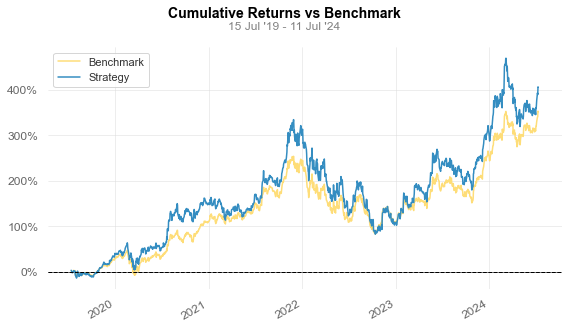

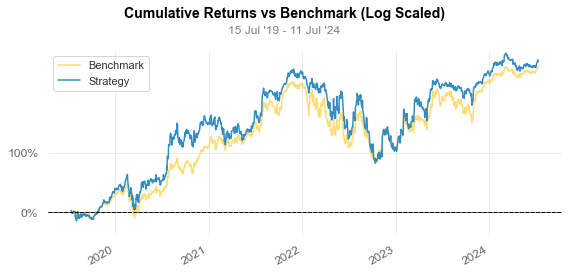

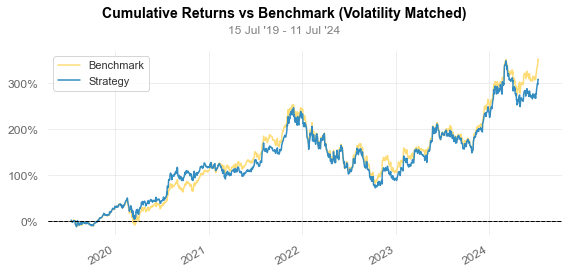

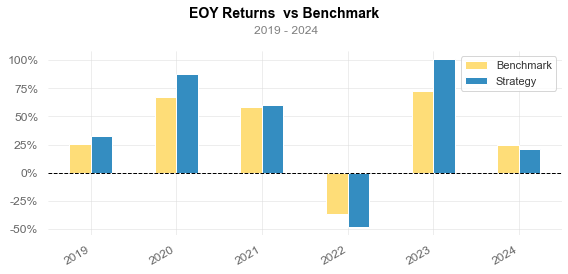

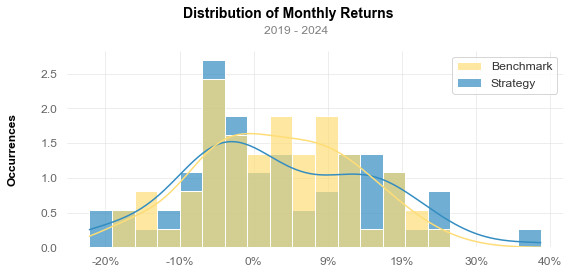

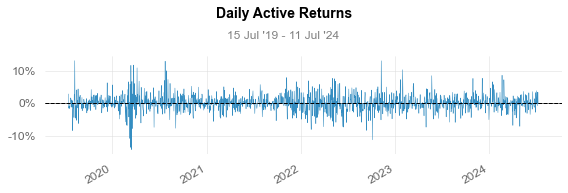

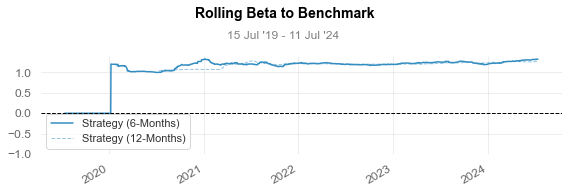

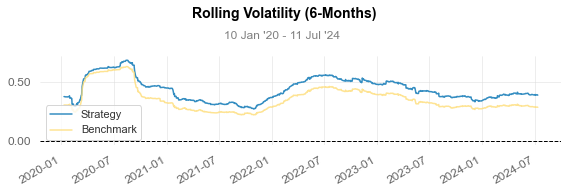

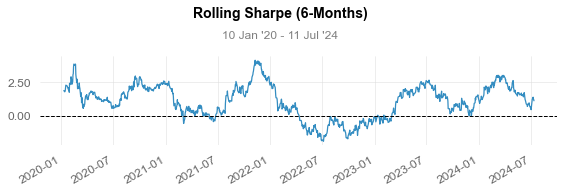

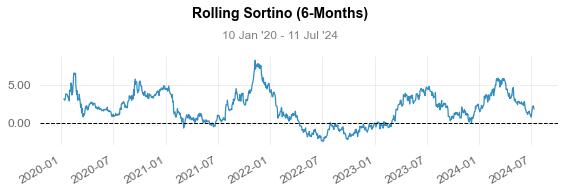

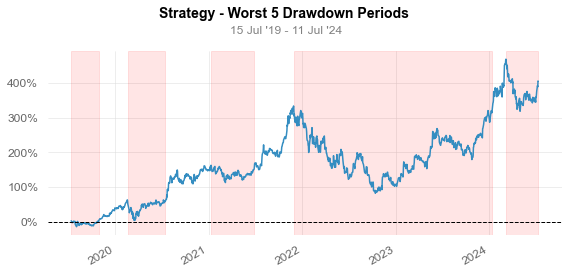

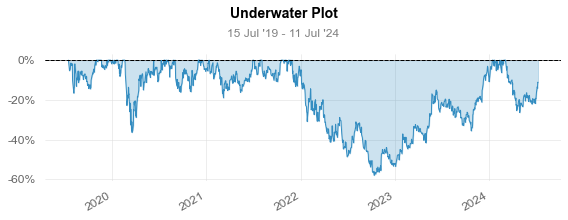

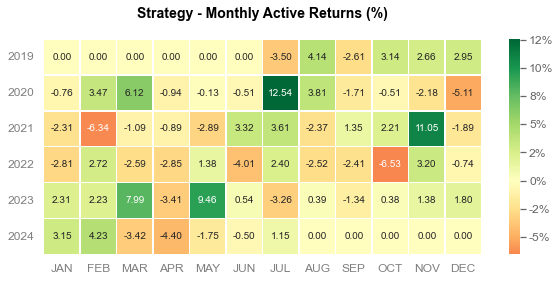

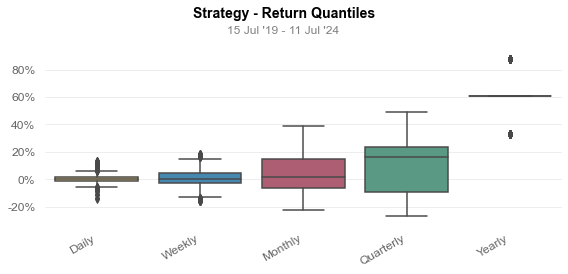

In [30]:
qs.reports.full(black_litterman_portfolio, benchmark = lagrange_portfolio)